# import

In [63]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

from datetime import datetime, timedelta 

import re

from itertools import combinations
from scipy.stats import ttest_ind

# Загружаем специальный удобный инструмент для разделения датасета:
from sklearn.model_selection import train_test_split

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/sf-dst-restaurant-rating/sample_submission.csv
/kaggle/input/sf-dst-restaurant-rating/main_task.csv
/kaggle/input/sf-dst-restaurant-rating/kaggle_task.csv


In [64]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42

In [65]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

# DATA

In [66]:
DATA_DIR = '/kaggle/input/sf-dst-restaurant-rating/'
df_train = pd.read_csv(DATA_DIR+'/main_task.csv')
df_test = pd.read_csv(DATA_DIR+'kaggle_task.csv')
sample_submission = pd.read_csv(DATA_DIR+'/sample_submission.csv')

In [67]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 10 columns):
Restaurant_id        40000 non-null object
City                 40000 non-null object
Cuisine Style        30717 non-null object
Ranking              40000 non-null float64
Rating               40000 non-null float64
Price Range          26114 non-null object
Number of Reviews    37457 non-null float64
Reviews              40000 non-null object
URL_TA               40000 non-null object
ID_TA                40000 non-null object
dtypes: float64(3), object(7)
memory usage: 3.1+ MB


In [68]:
df_train.head(5)

,Restaurant_id,City,Cuisine Style,Ranking,Rating,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA
0,id_5569,Paris,"['European', 'French', 'International']",5570.0,3.5,$$ - $$$,194.0,"[['Good food at your doorstep', 'A good hotel ...",/Restaurant_Review-g187147-d1912643-Reviews-R_...,d1912643
1,id_1535,Stockholm,NaN,1537.0,4.0,NaN,10.0,"[['Unique cuisine', 'Delicious Nepalese food']...",/Restaurant_Review-g189852-d7992032-Reviews-Bu...,d7992032
2,id_352,London,"['Japanese', 'Sushi', 'Asian', 'Grill', 'Veget...",353.0,4.5,$$$$,688.0,"[['Catch up with friends', 'Not exceptional'],...",/Restaurant_Review-g186338-d8632781-Reviews-RO...,d8632781
3,id_3456,Berlin,NaN,3458.0,5.0,NaN,3.0,"[[], []]",/Restaurant_Review-g187323-d1358776-Reviews-Es...,d1358776
4,id_615,Munich,"['German', 'Central European', 'Vegetarian Fri...",621.0,4.0,$$ - $$$,84.0,"[['Best place to try a Bavarian food', 'Nice b...",/Restaurant_Review-g187309-d6864963-Reviews-Au...,d6864963


In [69]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 9 columns):
Restaurant_id        10000 non-null object
City                 10000 non-null object
Cuisine Style        7693 non-null object
Ranking              10000 non-null float64
Price Range          6525 non-null object
Number of Reviews    9343 non-null float64
Reviews              9998 non-null object
URL_TA               10000 non-null object
ID_TA                10000 non-null object
dtypes: float64(2), object(7)
memory usage: 703.2+ KB


In [70]:
df_test.head(5)

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA
0,id_0,Paris,"['Bar', 'Pub']",12963.0,$$ - $$$,4.0,"[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-L...,d10746918
1,id_1,Helsinki,"['European', 'Scandinavian', 'Gluten Free Opti...",106.0,$$ - $$$,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",/Restaurant_Review-g189934-d6674944-Reviews-Ra...,d6674944
2,id_2,Edinburgh,['Vegetarian Friendly'],810.0,$$ - $$$,28.0,"[['Better than the Links', 'Ivy Black'], ['12/...",/Restaurant_Review-g186525-d13129638-Reviews-B...,d13129638
3,id_3,London,"['Italian', 'Mediterranean', 'European', 'Vege...",1669.0,$$$$,202.0,"[['Most exquisite', 'Delicious and authentic']...",/Restaurant_Review-g186338-d680417-Reviews-Qui...,d680417
4,id_4,Bratislava,"['Italian', 'Mediterranean', 'European', 'Seaf...",37.0,$$$$,162.0,"[['Always the best in bratislava', 'Very good ...",/Restaurant_Review-g274924-d1112354-Reviews-Ma...,d1112354


In [71]:
sample_submission.head(5)

,Restaurant_id,Rating
0,id_0,2.0
1,id_1,2.5
2,id_2,4.0
3,id_3,1.0
4,id_4,4.0


In [72]:
sample_submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 2 columns):
Restaurant_id    10000 non-null object
Rating           10000 non-null float64
dtypes: float64(1), object(1)
memory usage: 156.4+ KB


In [73]:
# ВАЖНО! дря корректной обработки признаков объединяем трейн и тест в один датасет
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['Rating'] = 0 # в тесте у нас нет значения Rating, мы его должны предсказать, по этому пока просто заполняем нулями

data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем

In [74]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
Restaurant_id        50000 non-null object
City                 50000 non-null object
Cuisine Style        38410 non-null object
Ranking              50000 non-null float64
Price Range          32639 non-null object
Number of Reviews    46800 non-null float64
Reviews              49998 non-null object
URL_TA               50000 non-null object
ID_TA                50000 non-null object
sample               50000 non-null int64
Rating               50000 non-null float64
dtypes: float64(3), int64(1), object(7)
memory usage: 4.2+ MB


Подробнее по признакам:
* City: Город 
* Cuisine Style: Кухня
* Ranking: Ранг ресторана относительно других ресторанов в этом городе
* Price Range: Цены в ресторане в 3 категориях
* Number of Reviews: Количество отзывов
* Reviews: 2 последних отзыва и даты этих отзывов
* URL_TA: страница ресторана на 'www.tripadvisor.com' 
* ID_TA: ID ресторана в TripAdvisor
* Rating: Рейтинг ресторана

In [75]:
data.sample(5)

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating
15704,id_1546,Lyon,['French'],1547.0,NaN,23.0,"[[], []]",/Restaurant_Review-g187265-d6427414-Reviews-Le...,d6427414,1,4.0
21752,id_7159,Madrid,NaN,7164.0,NaN,9.0,"[['Good for the everyday lunch'], ['07/11/2017']]",/Restaurant_Review-g187514-d10266752-Reviews-R...,d10266752,1,3.0
34298,id_861,Athens,NaN,863.0,NaN,19.0,"[['Metaxou / Athens', 'Nice place'], ['10/25/2...",/Restaurant_Review-g189400-d9599232-Reviews-Me...,d9599232,1,4.0
39336,id_13766,Paris,NaN,13768.0,NaN,NaN,"[[], []]",/Restaurant_Review-g187147-d1335659-Reviews-Ad...,d1335659,1,2.0
33765,id_1927,Stockholm,"['American', 'European']",1930.0,$$ - $$$,19.0,"[['Great find for food and jazz lovers', 'Food...",/Restaurant_Review-g189852-d1010057-Reviews-Re...,d1010057,1,3.5


In [76]:
# Смотрим количество уникальных значений в колонках:

for column_name in list(data.columns):
    print(column_name, len(data[column_name].unique()))

Restaurant_id 13094
City 31
Cuisine Style 10732
Ranking 12975
Price Range 4
Number of Reviews 1574
Reviews 41858
URL_TA 49963
ID_TA 49963
sample 2
Rating 10


1. **ОБРАБОТКА И СОЗДАНИЕ НОВЫХ ПРИЗНАКОВ**

**City**

In [128]:
def city_encode(data):
    # применим One-Hot Encoding
    data = pd.get_dummies(data, columns=[ 'City',], dummy_na=True)
#city_encode(data)

In [129]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 51 columns):
Restaurant_id                   50000 non-null object
Cuisine Style                   50000 non-null object
Ranking                         50000 non-null float64
Price Range                     50000 non-null object
Number of Reviews               50000 non-null float64
Reviews                         49998 non-null object
URL_TA                          50000 non-null object
ID_TA                           50000 non-null object
sample                          50000 non-null int64
Rating                          50000 non-null float64
Price_Range_Score               50000 non-null int64
Cuisine_Style_List              50000 non-null object
Quantity_оf_Cuisine             50000 non-null int64
Weighted_Quantity_of_Cuisine    50000 non-null float64
Quantity_of_Rest                50000 non-null float64
Norm_Ranking                    50000 non-null float64
Population              

**Price Range**

In [77]:

# Создаем словарь "город - самый популярный ценовой диапазон":
popular_range= {}

# Функция для заполнения словаря:
def popular_price_range (city):
    
    h_number = data[(data.City == city) & (data['Price Range']== '$$$$')].ID_TA.count()
    m_number = data[(data.City == city) & (data['Price Range']== '$$ - $$$')].ID_TA.count()
    l_number = data[(data.City == city) & (data['Price Range']== '$')].ID_TA.count()
    
    if (h_number > m_number) & (m_number >= l_number):
        result = '$$$$'
    elif (l_number > m_number) & (m_number >= h_number):
        result = '$'
    else:
        result = '$$ - $$$' 
    
    return result
           

# Заполняем словарь:
for city in list(data.City.unique()):
    popular_range[city] = popular_price_range (city)
    
popular_range

{'Paris': '$$ - $$$',
 'Helsinki': '$$ - $$$',
 'Edinburgh': '$$ - $$$',
 'London': '$$ - $$$',
 'Bratislava': '$$ - $$$',
 'Lisbon': '$$ - $$$',
 'Budapest': '$$ - $$$',
 'Stockholm': '$$ - $$$',
 'Rome': '$$ - $$$',
 'Milan': '$$ - $$$',
 'Munich': '$$ - $$$',
 'Hamburg': '$$ - $$$',
 'Prague': '$$ - $$$',
 'Vienna': '$$ - $$$',
 'Dublin': '$$ - $$$',
 'Barcelona': '$$ - $$$',
 'Brussels': '$$ - $$$',
 'Madrid': '$$ - $$$',
 'Oslo': '$$ - $$$',
 'Amsterdam': '$$ - $$$',
 'Berlin': '$$ - $$$',
 'Lyon': '$$ - $$$',
 'Athens': '$$ - $$$',
 'Warsaw': '$$ - $$$',
 'Oporto': '$$ - $$$',
 'Krakow': '$$ - $$$',
 'Copenhagen': '$$ - $$$',
 'Luxembourg': '$$ - $$$',
 'Zurich': '$$ - $$$',
 'Geneva': '$$ - $$$',
 'Ljubljana': '$$ - $$$'}

Средний ценовой диапазон самый популярный во всех городах.

In [78]:
# Price Range в числовые признаки от 1 до 3, где 1 соответствует самому низкому ценовому диапазону, а 3 - самому высокому, пропуски заполняем 2 -значением для среднего ценового диапазона, т.к. он самый популярный


data['Price Range'].fillna('$$ - $$$', inplace=True)

# Cоздаем словарь:
price_range= { 
                   '$':        1,
                   '$$ - $$$': 2,
                   '$$$$':     3
                    }

# Переводим признаки в числа в новой колонке Price Range Score:
data['Price_Range_Score'] = data['Price Range'].apply(lambda x: price_range[x])

display(data['Price_Range_Score'].value_counts())

2    40402
1     7816
3     1782
Name: Price_Range_Score, dtype: int64

**Number of Reviews**

In [79]:
#Смотрим минимальное количество отзывов:
min(list(data['Number of Reviews'].unique()))

2.0

In [80]:
#т.к. оно больше нуля, можем заменить пропуски на 0
data['Number of Reviews'].fillna(0, inplace=True)

**Cuisine Style**

In [81]:
# Заменяем все пропуски на "ordinary"
data['Cuisine Style'].fillna('ordinary', inplace=True)

In [82]:
# Преобразуем строковые значения из Cuisine Style в списки:
data['Cuisine_Style_List'] = data['Cuisine Style'].str.findall(r'\w+\s*\w*\s*\w*\s*\w*\s*\w*')

display(type(data.loc[0,'Cuisine Style']))        
display(type(data.loc[0,'Cuisine_Style_List']))   

str

list

In [83]:
# Создаем новый признак с количеством кухонь в ресторане
data['Quantity_оf_Cuisine'] = data['Cuisine_Style_List'].apply(lambda x: len(x))

data['Quantity_оf_Cuisine'].unique() 

array([ 2,  5,  1,  6,  3,  4,  7,  8,  9, 10, 15, 11, 13, 21])

In [84]:
# Среднее количество кухонь в одном ресторане:
data['Quantity_оf_Cuisine'].sum()/50000

2.62586

In [85]:
# Посмотрим на выброс c 21 кухней:
list(data[data['Quantity_оf_Cuisine'] == 21]['Cuisine_Style_List'])

[['Asian',
  'Italian',
  'French',
  'American',
  'Indian',
  'Dutch',
  'Bar',
  'Seafood',
  'Fast Food',
  'Mediterranean',
  'Sushi',
  'European',
  'Spanish',
  'Korean',
  'Turkish',
  'Grill',
  'Vietnamese',
  'Street Food',
  'Vegetarian Friendly',
  'Vegan Options',
  'Gluten Free Options']]

In [86]:
# Посмотрим список всех кухонь и их количество:
all_cuisines = list(pd.Series(data['Cuisine_Style_List'].sum()).unique())
all_cuisines.sort()
display(all_cuisines)

len(all_cuisines)

['Afghani',
 'African',
 'Albanian',
 'American',
 'Arabic',
 'Argentinean',
 'Armenian',
 'Asian',
 'Australian',
 'Austrian',
 'Azerbaijani',
 'Balti',
 'Bangladeshi',
 'Bar',
 'Barbecue',
 'Belgian',
 'Brazilian',
 'Brew Pub',
 'British',
 'Burmese',
 'Cafe',
 'Cajun ',
 'Cambodian',
 'Canadian',
 'Caribbean',
 'Caucasian',
 'Central American',
 'Central Asian',
 'Central European',
 'Chilean',
 'Chinese',
 'Colombian',
 'Contemporary',
 'Creole',
 'Croatian',
 'Cuban',
 'Czech',
 'Danish',
 'Delicatessen',
 'Diner',
 'Dutch',
 'Eastern European',
 'Ecuadorean',
 'Egyptian',
 'Ethiopian',
 'European',
 'Fast Food',
 'Filipino',
 'French',
 'Fujian',
 'Fusion',
 'Gastropub',
 'Georgian',
 'German',
 'Gluten Free Options',
 'Greek',
 'Grill',
 'Halal',
 'Hawaiian',
 'Healthy',
 'Hungarian',
 'Indian',
 'Indonesian',
 'International',
 'Irish',
 'Israeli',
 'Italian',
 'Jamaican',
 'Japanese',
 'Korean',
 'Kosher',
 'Latin',
 'Latvian',
 'Lebanese',
 'Malaysian',
 'Mediterranean',
 'Me

127

In [87]:
# Посчитаем как часто встречается та или иная кухня:
cuisines_sum = pd.Series(data['Cuisine_Style_List'].sum()).value_counts()
cuisines_sum

Vegetarian Friendly    14021
European               12561
ordinary               11590
Mediterranean           7820
Italian                 7433
                       ...  
Yunnan                     2
Salvadoran                 1
Burmese                    1
Latvian                    1
Xinjiang                   1
Length: 127, dtype: int64

In [88]:
# Посчитаем вес популярности каждой кухни

# Cчитаем сумму всех полей в cuisine_sum:
cuisines_sum_total = cuisines_sum.sum()

display(cuisines_sum_total)

# Создаем справочник весов кухонь и заполняем его:
cuisines_weights = {}
for cuisen in all_cuisines:
    cuisines_weights[cuisen] = round(cuisines_sum[cuisen] / cuisines_sum_total, 5)

display(cuisines_weights) 

131293

{'Afghani': 0.00021,
 'African': 0.00147,
 'Albanian': 6e-05,
 'American': 0.01251,
 'Arabic': 0.00044,
 'Argentinean': 0.00163,
 'Armenian': 0.00013,
 'Asian': 0.02884,
 'Australian': 0.00027,
 'Austrian': 0.00352,
 'Azerbaijani': 2e-05,
 'Balti': 0.00079,
 'Bangladeshi': 0.00076,
 'Bar': 0.03118,
 'Barbecue': 0.00541,
 'Belgian': 0.00255,
 'Brazilian': 0.00116,
 'Brew Pub': 0.00228,
 'British': 0.01517,
 'Burmese': 1e-05,
 'Cafe': 0.02196,
 'Cajun ': 0.00021,
 'Cambodian': 0.00017,
 'Canadian': 5e-05,
 'Caribbean': 0.00094,
 'Caucasian': 3e-05,
 'Central American': 0.00128,
 'Central Asian': 9e-05,
 'Central European': 0.01315,
 'Chilean': 0.00012,
 'Chinese': 0.01101,
 'Colombian': 0.00023,
 'Contemporary': 0.00497,
 'Creole': 0.00021,
 'Croatian': 0.00025,
 'Cuban': 0.00024,
 'Czech': 0.00567,
 'Danish': 0.00171,
 'Delicatessen': 0.0036,
 'Diner': 0.00286,
 'Dutch': 0.0028,
 'Eastern European': 0.00479,
 'Ecuadorean': 6e-05,
 'Egyptian': 0.00018,
 'Ethiopian': 0.00039,
 'European':

In [89]:
# Добавляем в таблицу колонку с количеством кухонь ресторана по популярности:

# Создаем функцию для заполнения колонки:
def w_number_of_c_func(x):
    
    sum_weights = 0
    for c in x:
        sum_weights = sum_weights + cuisines_weights[c]
    
    return sum_weights

data['Weighted_Quantity_of_Cuisine'] = data.Cuisine_Style_List.apply(lambda x: w_number_of_c_func(x))

data['Weighted_Quantity_of_Cuisine']

0        0.05447
1        0.28866
2        0.10679
3        0.35812
4        0.37242
          ...   
49995    0.24618
49996    0.27639
49997    0.02521
49998    0.22385
49999    0.02632
Name: Weighted_Quantity_of_Cuisine, Length: 50000, dtype: float64

**Ranking**

In [90]:
# Смотрим общее количество ресторанов в городе: 
Quantity_of_rest_data = data.groupby(['City'])['Ranking'].max()

Quantity_of_rest_data

City
Amsterdam      3254.0
Athens         1787.0
Barcelona      7796.0
Berlin         6372.0
Bratislava      889.0
Brussels       3006.0
Budapest       2440.0
Copenhagen     1964.0
Dublin         1960.0
Edinburgh      1766.0
Geneva         1413.0
Hamburg        2737.0
Helsinki       1141.0
Krakow         1244.0
Lisbon         3717.0
Ljubljana       468.0
London        16444.0
Luxembourg      621.0
Lyon           2666.0
Madrid         8809.0
Milan          6275.0
Munich         2763.0
Oporto         1484.0
Oslo           1137.0
Paris         13986.0
Prague         4188.0
Rome           5948.0
Stockholm      2464.0
Vienna         3444.0
Warsaw         2154.0
Zurich         1601.0
Name: Ranking, dtype: float64

In [91]:
# Добавляем в таблицу колонку c общим количеством ресторанов в городе:
data['Quantity_of_Rest'] = data.apply(lambda row: Quantity_of_rest_data[row.City],axis = 1)

data['Quantity_of_Rest'].nunique() == 31 

True

In [92]:
# Добавляем в таблицу колонку c нормализованным рангом ресторана в городе:
data['Norm_Ranking'] = round(data.apply(lambda row: row.Ranking 
                                   / Quantity_of_rest_data[row.City], axis = 1),2)

data['Norm_Ranking']

0        0.93
1        0.09
2        0.46
3        0.10
4        0.04
         ... 
49995    0.08
49996    0.45
49997    0.67
49998    0.30
49999    0.77
Name: Norm_Ranking, Length: 50000, dtype: float64

In [93]:
# Добавляем дополнительные признаки с численностью населения и количеством ресторанов на 1000 жителей

# Создаем словарь с численностью населения городов в тыс.чел.(данные из Википедии)

population_size_dict = { 
'Amsterdam' :    873,
'Athens' :       656,
'Barcelona' :   1637,
'Berlin' :      3669,
'Bratislava' :   438,
'Brussels' :    1211,
'Budapest' :    1768,
'Copenhagen' :   616,
'Dublin' :      1173,
'Edinburgh' :    488,
'Geneva' :       496,
'Hamburg' :     1899,
'Helsinki' :     655,
'Krakow' :       779,
'Lisbon' :       507,
'Ljubljana' :    284,
'London' :      9126,
'Luxembourg' :   115,
'Lyon' :         516,
'Madrid' :      3335,
'Milan' :       1404,
'Munich' :      1472,
'Oporto' :       268,
'Oslo' :         673,
'Paris' :       2148,
'Prague' :      1324,
'Rome' :        2791,
'Stockholm' :    962,
'Vienna' :      1921,
'Warsaw' :      1794,
'Zurich' :       429
}

# Добавляем в таблицу колонку с численностью населения в городе:
data['Population'] = data.apply(lambda row: population_size_dict[row.City],axis = 1)

display(data['Population']) # проверка

# Создаем колонку с уровнем конкуренции в городе(кол-вом ресторанов на 1000 чел):
data['Competition'] = round(data.apply(lambda row: Quantity_of_rest_data[row.City] 
                                 / population_size_dict[row.City], axis = 1),1)

display(data['Competition']) 

0        2148
1         655
2         488
3        9126
4         438
         ... 
49995    1404
49996    2148
49997     962
49998    1794
49999    1404
Name: Population, Length: 50000, dtype: int64

0        6.5
1        1.7
2        3.6
3        1.8
4        2.0
        ... 
49995    4.5
49996    6.5
49997    2.6
49998    1.2
49999    4.5
Name: Competition, Length: 50000, dtype: float64

**Restaurant_id**

In [94]:
# Создаем таблицу с общим количеством ресторанов с одинаковым id: 
Quantity_of_id = data.groupby(['Restaurant_id'])['Ranking'].count()

Quantity_of_id.sum() == 50000 

True

In [111]:
# Добавляем в таблицу колонку c общим количеством ресторанов c одинаковым рeйтингом:
data['Quantity_of_id'] = data.apply(lambda row: Quantity_of_id[row.Restaurant_id],axis = 1)

data['Quantity_of_id'].nunique() == Quantity_of_id.nunique()

True

**Reviews**

In [ ]:
data.Reviews.value_counts()


In [ ]:
# Запоняем пропуски самым популярным значением:
data.Reviews.fillna('[[],[]]', inplace = True)

In [ ]:
def set_reviews_date_delta(data):
    # Определим дельту между отзывами
    pattern = re.compile('\d+[/]\d+[/]\d+')
    data['Reviews Date'] = data['Reviews'].apply(lambda x: pattern.findall(str(x)))
    data['Reviews Date'] = data['Reviews Date'].apply(lambda x: [pd.to_datetime(i).date() for i in x])
    data['Reviews Date Delta'] = data['Reviews Date'].apply(lambda x: (x[0] - x[len(x)-1]) if len(x)>0 else None)
    data['Reviews Date Delta'] = data['Reviews Date Delta'].dt.days
    
    # Заполним пропуски средним значением
    data['Reviews Date Delta'] = data['Reviews Date Delta'].fillna(round(data.groupby('City')['Reviews Date Delta'].transform('mean')))

In [ ]:
set_reviews_date_delta(data)

2.**EDA**

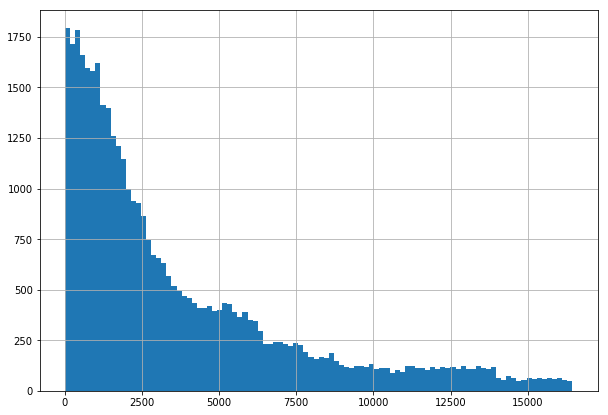

In [97]:
#Распределение признаков:

plt.rcParams['figure.figsize'] = (10,7)
df_train['Ranking'].hist(bins=100)
    
    

У нас много ресторанов, которые не дотягивают и до 2500 места в своем городе, а что там по городам?


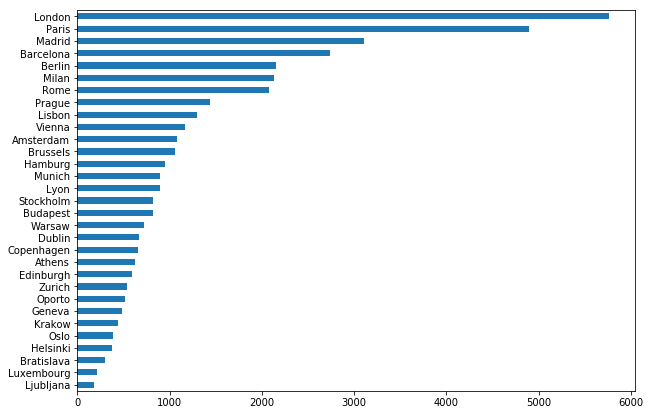

In [98]:
df_train['City'].value_counts(ascending=True).plot(kind='barh')

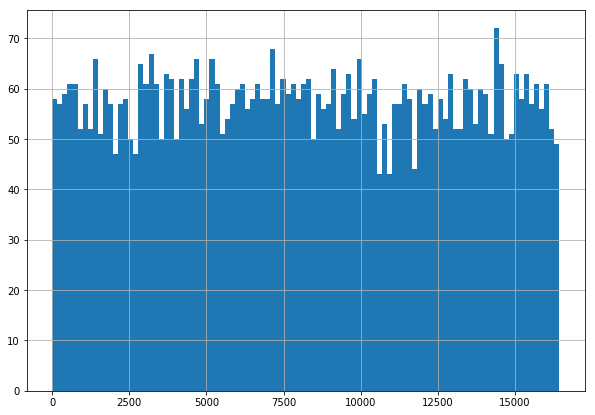

In [99]:
df_train['Ranking'][df_train['City'] =='London'].hist(bins=100)

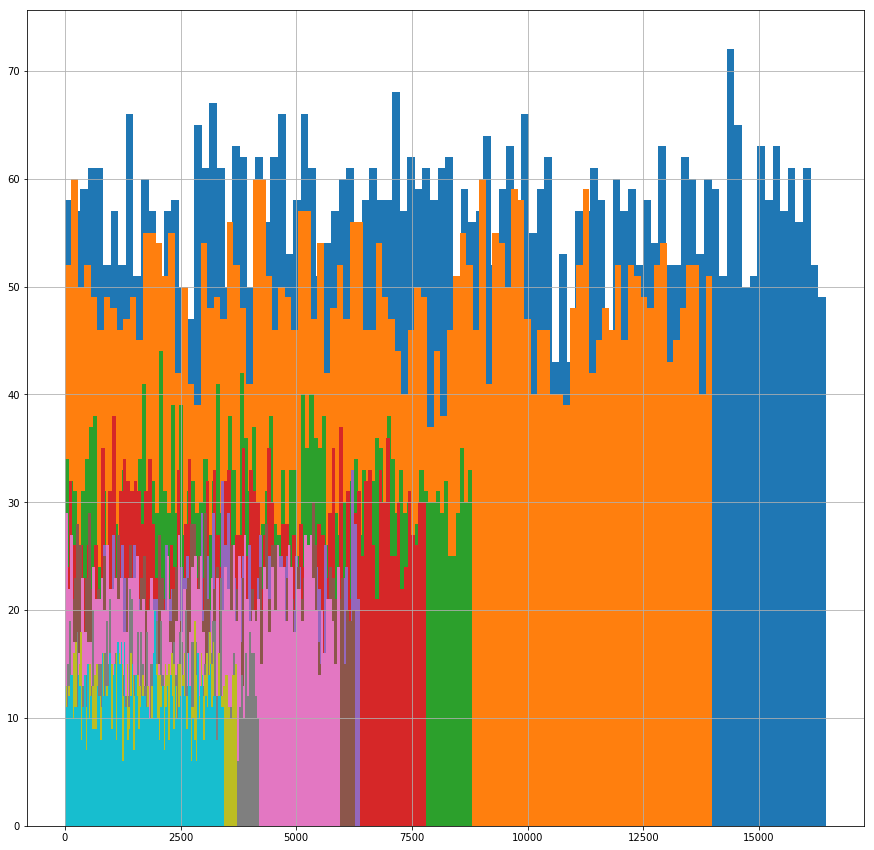

In [114]:
# посмотрим на топ 10 городов
for x in (df_train['City'].value_counts())[0:10].index:
    df_train['Ranking'][df_train['City'] == x].hist(bins=100)
plt.show()

Получается, что Ranking имеет нормальное распределение, просто в больших городах больше ресторанов, из-за мы этого имеем смещение. 

**Оаспределение целевой переменной**

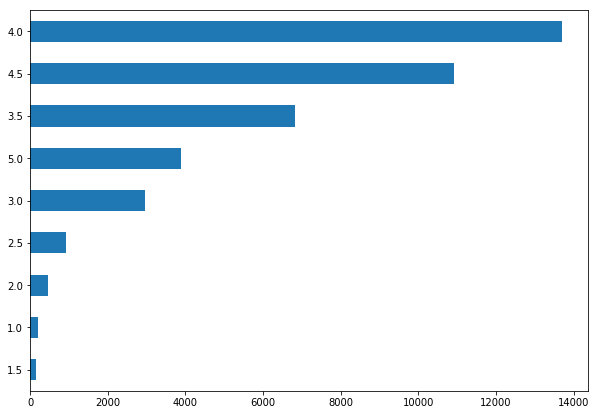

In [100]:
df_train['Rating'].value_counts(ascending=True).plot(kind='barh')

**Посмотрим распределение целевой переменной относительно признака**

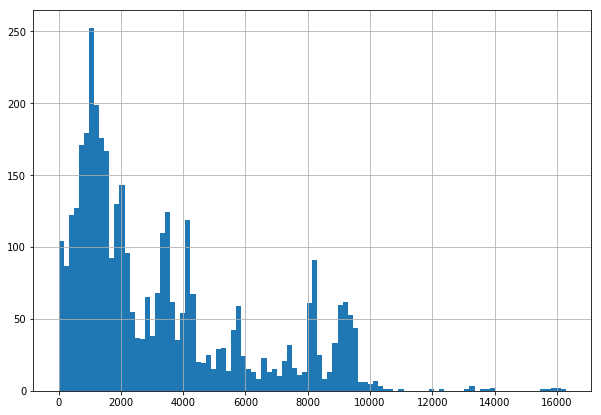

In [101]:
df_train['Ranking'][df_train['Rating'] == 5].hist(bins=100)

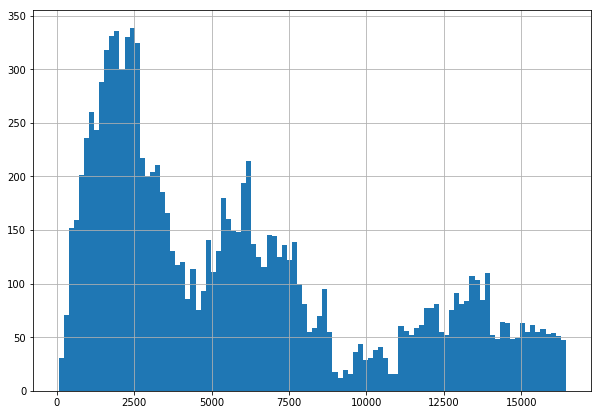

In [102]:
df_train['Ranking'][df_train['Rating'] < 4].hist(bins=100)

**Корреляция признаков**

In [108]:
# Сфорсмруем список признаков, которые исключаем из корреляционного анализа
cols_to_drop = ['sample', 'City_Amsterdam',  'City_Athens',  'City_Barcelona', 'City_Berlin',  
                'City_Bratislava',  'City_Brussels',  'City_Budapest',  'City_Copenhagen',  
                'City_Dublin',  'City_Edinburgh',  'City_Geneva',  'City_Hamburg',  
                'City_Helsinki', 'City_Krakow',  'City_Lisbon',  'City_Ljubljana',  
                'City_London',  'City_Luxembourg',  'City_Lyon',  'City_Madrid',  'City_Milan',  
                'City_Munich',  'City_Oporto',  'City_Oslo',  'City_Paris', 'City_Prague',  
                'City_Rome',  'City_Stockholm',  'City_Vienna',  'City_Warsaw',  'City_Zurich',  
                'City_nan']
                

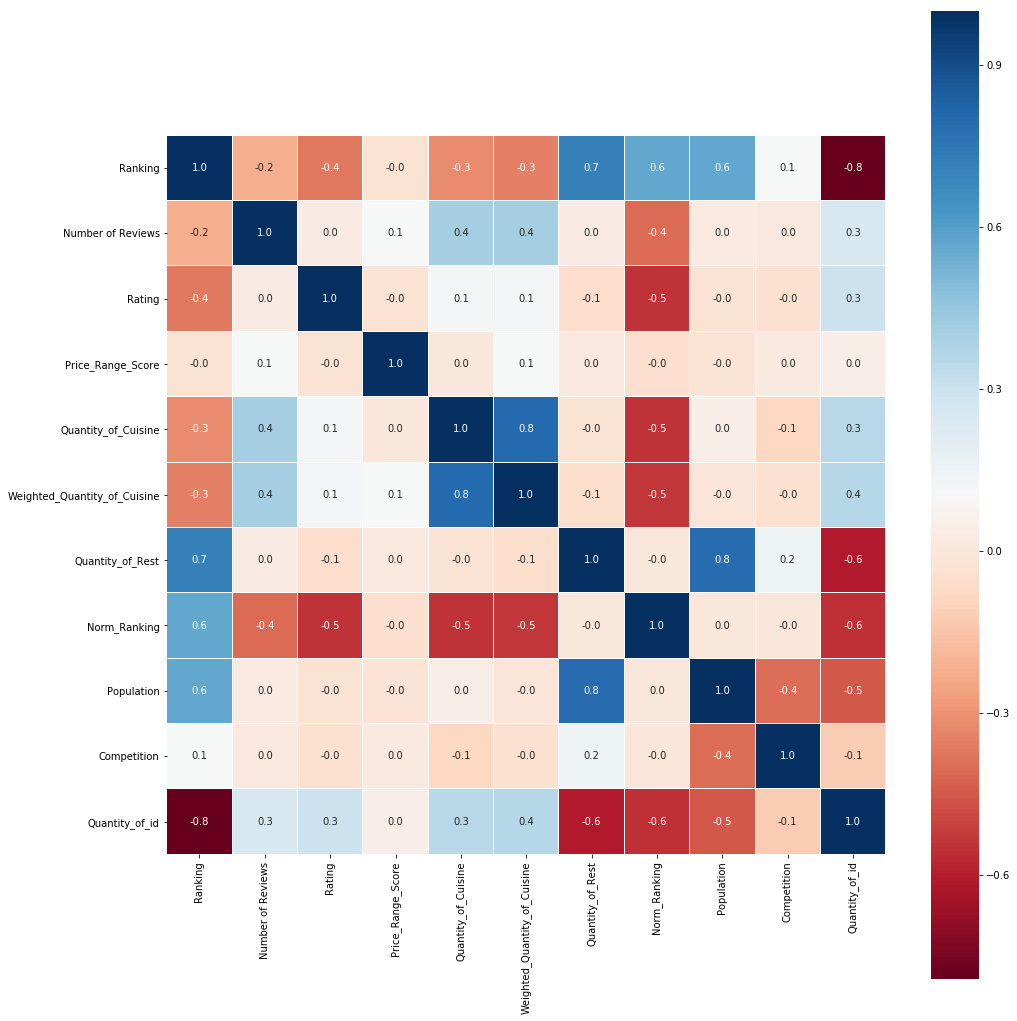

In [131]:
plt.rcParams['figure.figsize'] = (15,15)
data_corr = data
sns.heatmap(data_corr[data_corr['sample']== 1].drop(cols_to_drop, axis=1).corr(), square=True,
            annot=True, fmt=".1f", linewidths=0.1, cmap="RdBu");
plt.tight_layout()

**ОБРАБОТКА ДАННЫХ**

In [137]:
# df_preproc = preproc_data(data)
df_preproc = data

In [138]:
# Убираем ненужные признаки:

# Убираем коллинераные признаки:
df_preproc.drop(['Quantity_of_id','Population','Quantity_оf_Cuisine'], axis = 1, inplace=True)

# модель на признаках с dtypes "object" обучаться не будет, просто выберим их и удалим
object_columns = [s for s in df_preproc.columns if df_preproc[s].dtypes == 'object']
df_preproc.drop(object_columns, axis = 1, inplace=True)

df_preproc.sample(10)

,Ranking,Number of Reviews,sample,Rating,Price_Range_Score,Weighted_Quantity_of_Cuisine,Quantity_of_Rest,Norm_Ranking,Competition,City_Amsterdam,...,City_Oporto,City_Oslo,City_Paris,City_Prague,City_Rome,City_Stockholm,City_Vienna,City_Warsaw,City_Zurich,City_nan
38302,2875.0,46.0,1,4.5,2,0.22784,16444.0,0.17,1.8,0,...,0,0,0,0,0,0,0,0,0,0
26636,3998.0,20.0,1,4.0,2,0.08828,5948.0,0.67,2.1,0,...,0,0,0,0,1,0,0,0,0,0
4060,443.0,19.0,0,0.0,2,0.08828,1137.0,0.39,1.7,0,...,0,1,0,0,0,0,0,0,0,0
3978,807.0,3.0,0,0.0,2,0.09567,1601.0,0.50,3.7,0,...,0,0,0,0,0,0,0,0,1,0
27124,2294.0,65.0,1,4.0,2,0.18155,7796.0,0.29,4.8,0,...,0,0,0,0,0,0,0,0,0,0
10469,7424.0,44.0,1,2.5,2,0.18155,7796.0,0.95,4.8,0,...,0,0,0,0,0,0,0,0,0,0
42944,575.0,35.0,1,4.5,2,0.08828,3006.0,0.19,2.5,0,...,0,0,0,0,0,0,0,0,0,0
1187,24.0,276.0,0,0.0,2,0.23270,621.0,0.04,5.4,0,...,0,0,0,0,0,0,0,0,0,0
22279,16263.0,4.0,1,2.5,2,0.02667,16444.0,0.99,1.8,0,...,0,0,0,0,0,0,0,0,0,0
23282,698.0,90.0,1,4.5,2,0.20246,2763.0,0.25,1.9,0,...,0,0,0,0,0,0,0,0,0,0


In [139]:
df_preproc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 41 columns):
Ranking                         50000 non-null float64
Number of Reviews               50000 non-null float64
sample                          50000 non-null int64
Rating                          50000 non-null float64
Price_Range_Score               50000 non-null int64
Weighted_Quantity_of_Cuisine    50000 non-null float64
Quantity_of_Rest                50000 non-null float64
Norm_Ranking                    50000 non-null float64
Competition                     50000 non-null float64
City_Amsterdam                  50000 non-null uint8
City_Athens                     50000 non-null uint8
City_Barcelona                  50000 non-null uint8
City_Berlin                     50000 non-null uint8
City_Bratislava                 50000 non-null uint8
City_Brussels                   50000 non-null uint8
City_Budapest                   50000 non-null uint8
City_Copenhagen              

In [140]:
# Теперь выделим тестовую часть
train_data = df_preproc.query('sample == 1').drop(['sample'], axis=1)
test_data = df_preproc.query('sample == 0').drop(['sample'], axis=1)

y = train_data.Rating.values            
X = train_data.drop(['Rating'], axis=1)


**Перед тем как отправлять наши данные на обучение, разделим данные на еще один тест и трейн, для валидации. Это поможет нам проверить, как хорошо наша модель работает, до отправки submissiona на kaggle.**

In [141]:
# Воспользуемся специальной функцией train_test_split для разбивки тестовых данных
# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [142]:
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((10000, 40), (40000, 40), (40000, 39), (32000, 39), (8000, 39))

**Model**

Сам ML

In [143]:
# Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

In [144]:
# Создаём модель (НАСТРОЙКИ НЕ ТРОГАЕМ)
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

In [145]:
# Обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    7.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


In [146]:
# Так как признак рейтинга имеет шаг 0.5, округляем предсказание.
y_pred = np.round(y_pred * 2) / 2

In [147]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))

MAE: 0.178125


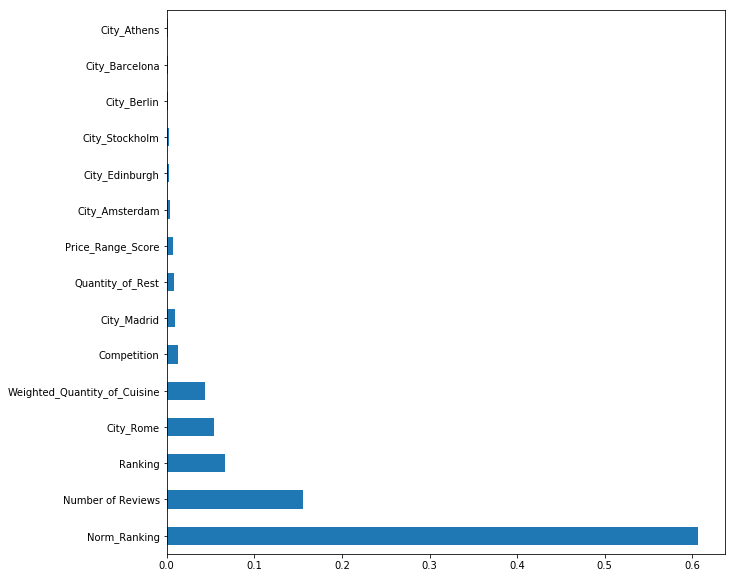

In [148]:
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')

**SUBMISSION**

In [149]:
test_data.sample(10)

,Ranking,Number of Reviews,Rating,Price_Range_Score,Weighted_Quantity_of_Cuisine,Quantity_of_Rest,Norm_Ranking,Competition,City_Amsterdam,City_Athens,...,City_Oporto,City_Oslo,City_Paris,City_Prague,City_Rome,City_Stockholm,City_Vienna,City_Warsaw,City_Zurich,City_nan
6964,3288.0,10.0,0.0,2,0.08828,6275.0,0.52,4.5,0,0,...,0,0,0,0,0,0,0,0,0,0
6400,6151.0,45.0,0.0,1,0.09944,8809.0,0.70,2.6,0,0,...,0,0,0,0,0,0,0,0,0,0
9088,512.0,17.0,0.0,2,0.19646,1960.0,0.26,1.7,0,0,...,0,0,0,0,0,0,0,0,0,0
1260,540.0,90.0,0.0,2,0.12846,3006.0,0.18,2.5,0,0,...,0,0,0,0,0,0,0,0,0,0
8328,2031.0,4.0,0.0,2,0.05661,3717.0,0.55,7.3,0,0,...,0,0,0,0,0,0,0,0,0,0
6451,5470.0,23.0,0.0,2,0.02906,6372.0,0.86,1.7,0,0,...,0,0,0,0,0,0,0,0,0,0
4510,12251.0,10.0,0.0,2,0.01616,16444.0,0.75,1.8,0,0,...,0,0,0,0,0,0,0,0,0,0
2969,1122.0,13.0,0.0,2,0.08828,2763.0,0.41,1.9,0,0,...,0,0,0,0,0,0,0,0,0,0
680,14189.0,56.0,0.0,1,0.18341,16444.0,0.86,1.8,0,0,...,0,0,0,0,0,0,0,0,0,0
192,5740.0,32.0,0.0,2,0.12196,16444.0,0.35,1.8,0,0,...,0,0,0,0,0,0,0,0,0,0


In [150]:
test_data = test_data.drop(['Rating'], axis=1)


In [151]:
sample_submission

,Restaurant_id,Rating
0,id_0,2.0
1,id_1,2.5
2,id_2,4.0
3,id_3,1.0
4,id_4,4.0
...,...,...
9995,id_9995,3.0
9996,id_9996,1.5
9997,id_9997,4.5
9998,id_9998,1.0


In [152]:
predict_submission = model.predict(test_data)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


In [153]:
# Так как признак рейтинга имеет шаг 0.5, округляем предсказание.
predict_submission = np.round(predict_submission * 2) / 2

In [154]:
predict_submission

array([3. , 4. , 4.5, ..., 3. , 4.5, 4. ])

In [155]:
sample_submission['Rating'] = predict_submission
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)

,Restaurant_id,Rating
0,id_0,3.0
1,id_1,4.0
2,id_2,4.5
3,id_3,4.5
4,id_4,4.5
5,id_5,4.5
6,id_6,1.5
7,id_7,3.5
8,id_8,4.0
9,id_9,4.5
